# Semantic Code Search using Transformers - Part II
by:
### Maj Ashish Ahluwalia (21111073) ashisha21@iitk.ac.in
### Binay Kumar Suna (21111021) binayas21@iitk.ac.in
### Chabil Kansal (21111022) chabilk21@iitk.ac.in
### Shubham Sinha (21111409) shubhams21@iitk.ac.in


In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install astor
!pip install tokenizers

In [4]:
#importing libraries

import ast
import sqlite3
import os

import glob
import re
import numpy as np
from pathlib import Path


import astor
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split

In [8]:
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import re

In [10]:
inp=pd.read_csv('./drive/MyDrive/CS657 IR PROJECT/function_tokens.txt',names=['functions'])

In [ ]:
inp.head()

In [12]:
target=pd.read_csv('./drive/MyDrive/CS657 IR PROJECT/docstrings.txt',names=['docstrings'])

In [13]:
target.head()

,docstrings
0,Convert decimal to degrees decimal minutes
1,Given two dicts merge them into a new dict as ...
2,setLineEnds ( self start end )
3,CAS to Mach conversion
4,Convert RA hours minutes seconds into an angle...


In [16]:
dataset = tf.data.Dataset.from_tensor_slices((inp.values, target.values))

In [17]:
import tokenizers

#Docstring tokenizer
tokenizer_doc = tokenizers.BertWordPieceTokenizer(
    vocab=None,
    strip_accents=True,
    lowercase=True,
    wordpieces_prefix='##'
)

#Generating the vocabulary of 30000 words from the docstrings
tokenizer_doc.train(
    files=['./drive/MyDrive/CS657 IR PROJECT/docstrings.txt'],
    vocab_size=30000,
    min_frequency=2,
    limit_alphabet=1000
)

#encoding using the docstring tokenizer
encoded = tokenizer_doc.encode(query_string)
print(encoded.ids) # Getting the ids for the docstring tokens
print(encoded.tokens) # Getting the docstring tokens

#saving the docstring tokenizer
tokenizer_doc.save("./doctrings")

#Function tokenizer
tokenizer_func = tokenizers.BertWordPieceTokenizer(
    vocab=None,
    strip_accents=True,
    lowercase=True,
    wordpieces_prefix ='##'
)

#Generating the vocabulary of 30000 words from the function tokens
tokenizer_func.train(
    files=['./drive/MyDrive/CS657 IR PROJECT/function_tokens.txt'],
    vocab_size=30000,
    min_frequency=2,
    limit_alphabet=1000
)

#encoding using the function tokenizer
encoded = tokenizer_func.encode(query_string)
print(encoded.ids) # Getting the ids for the docstring tokens
print(encoded.tokens) # Getting the docstring tokens

#saving the function tokenizer
tokenizer_func.save("./function_tokens")

[1201, 1168, 3382, 1359]
['return', 'the', 'vertex', 'id']
[112, 279, 2881, 155]
['return', 'the', 'vertex', 'id']


In [18]:
def encode(lang1, lang2):
    # adding the [CLS] token as start token and [SEP] token as end token 

    lang1 = tokenizer_func.encode("[CLS] " + [l.decode("utf-8")  for l in lang1.numpy()][0] + " [SEP]").ids
    lang2 = tokenizer_doc.encode("[CLS] " + [l.decode("utf-8")  for l in lang2.numpy()][0] + " [SEP]").ids
  
    return lang1, lang2


def tf_encode(func, doc):
    result_func, result_doc = tf.py_function(encode, [func, doc], [tf.int64, tf.int64])
    result_func.set_shape([None])
    result_doc.set_shape([None])

    return result_func, result_doc

In [19]:
BATCH_SIZE = 128

In [20]:
def filter_max_length(x, y):
    return tf.logical_and(tf.size(x) <= 300, tf.size(y) <= 50)

In [21]:
for index,i in enumerate(dataset):
    print(i)
    if(index == 5):
        break

(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'dd dd float 3600 return'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Convert decimal to degrees decimal minutes'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'merge keywords copy update return'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'Given two dicts merge them into a new dict as a shallow copy .'],
      dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'checkparent self return fitz annot'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'setLineEnds ( self start end )'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'cas tas cas tas return'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'CAS to Mach conversion'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'hmstodeg return degperhmshour degperhmsmin degperhmssec'],
      dtype=object)>, <

In [22]:
# Create train and val dataset

train_dataset = dataset.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
print(train_dataset)

# Only pad the dataset DO NOT shuffle
train_dataset = train_dataset.padded_batch(BATCH_SIZE) #https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch

#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) 

<FilterDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [23]:
ft_batch, en_batch = next(iter(train_dataset))
ft_batch, en_batch

(<tf.Tensor: shape=(128, 21), dtype=int64, numpy=
 array([[    2,  1892,  1892, ...,     0,     0,     0],
        [    2,  1692,  2393, ...,     0,     0,     0],
        [    2, 21326,    87, ...,     0,     0,     0],
        ...,
        [    2,   210,    87, ...,     0,     0,     0],
        [    2,  4833,   675, ...,     0,     0,     0],
        [    2,  1928,   150, ...,     0,     0,     0]])>,
 <tf.Tensor: shape=(128, 47), dtype=int64, numpy=
 array([[   2, 1472, 4394, ...,    0,    0,    0],
        [   2, 1272, 1786, ...,    0,    0,    0],
        [   2, 1292, 2471, ...,    0,    0,    0],
        ...,
        [   2, 1292,   62, ...,    0,    0,    0],
        [   2, 1788,   66, ...,    0,    0,    0],
        [   2, 2445,   62, ...,    0,    0,    0]])>)

5
(1, 50, 512)


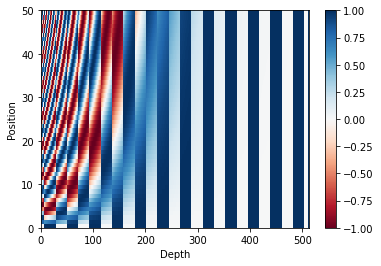

In [24]:
# Position Encoding
print(11//2) 

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates



def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)



pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [25]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
 
    return seq[:, tf.newaxis, tf.newaxis, :]  

In [26]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [27]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True) 
  

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  

    output = tf.matmul(attention_weights, v)  

    return output, attention_weights

In [28]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [29]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model  # typically 512

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  
        k = self.wk(k)  
        v = self.wv(v)  

        q = self.split_heads(q, batch_size)  
        k = self.split_heads(k, batch_size)  
        v = self.split_heads(v, batch_size) 


        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  

        output = self.dense(concat_attention)  

        return output, attention_weights

In [30]:
def point_wise_feed_forward_network(d_model, dff): #dff =512
    return tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
          tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
      ])

In [31]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model) # with Attention

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model) #with Attention

        return out2

In [32]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
          x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'input_vocab_size':self.input_vocab_size,
            'maximum_position_encoding':self.maximum_position_encoding,
            'rate':self.rate
        })
        return config

In [33]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [34]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'target_vocab_size':self.target_vocab_size,
            'maximum_position_encoding':self.maximum_position_encoding,
            'rate':self.rate
        })
        return config

In [35]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'input_vocab_size':self.input_vocab_size,
            'target_vocab_size':self.target_vocab_size,
            'pe_input':self.pe_input,
            'pe_target':self.pe_target,
            'rate':self.rate
        })
        return config

In [36]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8


input_vocab_size = 30000
target_vocab_size = 30000
dropout_rate = 0.1

In [37]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [38]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

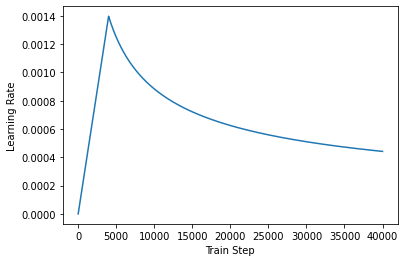

In [39]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [40]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [41]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [42]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [43]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [44]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
  
  
    
    dec_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [45]:
checkpoint_path = "./checkpoint"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [46]:
EPOCHS = 15

In [47]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [48]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
  

    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6929 Accuracy 0.0841
Epoch 1 Batch 50 Loss 4.2543 Accuracy 0.0891
Epoch 1 Batch 100 Loss 4.2138 Accuracy 0.0921
Epoch 1 Batch 150 Loss 4.1654 Accuracy 0.0944
Epoch 1 Batch 200 Loss 4.1441 Accuracy 0.0954
Epoch 1 Batch 250 Loss 4.1241 Accuracy 0.0964
Epoch 1 Batch 300 Loss 4.1026 Accuracy 0.0977
Epoch 1 Batch 350 Loss 4.0994 Accuracy 0.0980
Epoch 1 Batch 400 Loss 4.0967 Accuracy 0.0982
Epoch 1 Batch 450 Loss 4.0957 Accuracy 0.0984
Epoch 1 Batch 500 Loss 4.0908 Accuracy 0.0985
Epoch 1 Batch 550 Loss 4.0849 Accuracy 0.0987
Epoch 1 Batch 600 Loss 4.0789 Accuracy 0.0991
Epoch 1 Batch 650 Loss 4.0760 Accuracy 0.0994
Epoch 1 Batch 700 Loss 4.0761 Accuracy 0.0994
Epoch 1 Batch 750 Loss 4.0757 Accuracy 0.0995
Epoch 1 Batch 800 Loss 4.0771 Accuracy 0.0996
Epoch 1 Batch 850 Loss 4.0775 Accuracy 0.0997
Epoch 1 Batch 900 Loss 4.0770 Accuracy 0.0997
Epoch 1 Batch 950 Loss 4.0814 Accuracy 0.0996
Epoch 1 Batch 1000 Loss 4.0823 Accuracy 0.0997
Epoch 1 Batch 1050 Loss 4.0856 Accur

In [49]:
ckpt_save_path = ckpt_manager.save()

In [50]:
print(ckpt_manager.checkpoints)

['./checkpoint/ckpt-1', './checkpoint/ckpt-2', './checkpoint/ckpt-3', './checkpoint/ckpt-4', './checkpoint/ckpt-5']


In [51]:
def evaluate(inp_sentence):
  
  # inp is function tokens, adding the start and end token
    inp_sentence = tokenizer_func.encode("[CLS]"+inp_sentence+"[SEP]").ids
    encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
    decoder_input = tokenizer_doc.encode("[CLS]").ids
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(50):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == 3:
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [52]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
  
    predicted_sentence = tokenizer_doc.decode([i for i in result 
                                            if i < 30000])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

In [53]:
x=pd.read_csv('./drive/MyDrive/CS657 IR PROJECT/function_tokens.txt',names=['functions'])
y = pd.read_csv('./drive/MyDrive/CS657 IR PROJECT/docstrings.txt',names=['docstrings'])

In [54]:
translate(x['functions'][72])
print ("Real translation: ",y['docstrings'][72])

Input: getrect self return self self self self
Predicted translation: return the number of items in the current window.
Real translation:  Returns the window bounds as a tuple of ( x y w h )


In [66]:
translate(x['functions'][20998])
print ("Real translation: ",y['docstrings'][20999])

Input: apply object args none kwargs none if args is none args if kwargs is none kwargs return object args kwargs
Predicted translation: apply a function to a list of objects.
Real translation:  Make new Term from an Pauli operator


In [67]:
translate(x['functions'][21000])
print ("Real translation: ",y['docstrings'][21000])

Input: generate accounts seeds return seed privatekey encode hex seed address encode hex privatekey to address seed for seed in seeds
Predicted translation: generate a new list of dicts for the given seed.
Real translation:  Create private keys and addresses for all seeds .


In [59]:
def translate2(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
  
    predicted_sentence = tokenizer_doc.decode([i for i in result 
                                            if i < 30000])  
    return predicted_sentence

In [62]:
# %%timeit
translations = {}
for i in range(len(x['functions'])):
    print(i)
    translations[i] = translate2(x['functions'][i])
print("done")

25000
25001
25002
25003
25004
25005
25006
25007
25008
25009
25010
25011
25012
25013
25014
25015
25016
25017
25018
25019
25020
25021
25022
25023
25024
25025
25026
25027
25028
25029
25030
25031
25032
25033
25034
25035
25036
25037
25038
25039
25040
25041
25042
25043
25044
25045
25046
25047
25048
25049
25050
25051
25052
25053
25054
25055
25056
25057
25058
25059
25060
25061
25062
25063
25064
25065
25066
25067
25068
25069
25070
25071
25072
25073
25074
25075
25076
25077
25078
25079
25080
25081
25082
25083
25084
25085
25086
25087
25088
25089
25090
25091
25092
25093
25094
25095
25096
25097
25098
25099
25100
25101
25102
25103
25104
25105
25106
25107
25108
25109
25110
25111
25112
25113
25114
25115
25116
25117
25118
25119
25120
25121
25122
25123
25124
25125
25126
25127
25128
25129
25130
25131
25132
25133
25134
25135
25136
25137
25138
25139
25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151
25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
2516

KeyboardInterrupt: ignored

In [64]:
import json

with open("/content/drive/MyDrive/CS657 IR PROJECT/jsons/translations.json", "w") as outfile:
    json.dump(translations, outfile)

Part 2 Completed